In [1]:
import os
import sys
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, LSTM
import time
import mlflow
import mlflow.sklearn
import mlflow.tensorflow

In [2]:
# stop warnings
import warnings 
warnings.filterwarnings('ignore')

In [3]:
sys.path.append('../scripts')

In [4]:
# Load the datasets
creditcard_data = pd.read_csv('../data/creditcard.csv')
fraud_data = pd.read_csv('../data/fraud_data_preprocessed.csv')

In [5]:
fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,lower_bound_ip_address,upper_bound_ip_address,transaction_frequency,purchase_time_diff,hour_of_day,day_of_week
0,-1.735035,2015-01-11 03:47:13,2015-02-21 10:03:37,0.931338,27684,2,0,0,-0.944649,-1.018771,-0.321436,171,-0.616801,-0.606369,0.0,0.0,10,5
1,-1.735017,2015-06-02 16:40:57,2015-09-26 21:32:16,0.221836,65372,1,4,0,0.563874,0.507621,-0.321436,157,0.969966,0.969161,0.0,0.0,21,5
2,-1.734983,2015-05-28 07:53:06,2015-08-13 11:53:07,0.549298,96071,2,0,1,-0.944649,-1.438605,-0.321436,171,-1.048172,-1.038355,0.0,0.0,11,3
3,-1.734974,2015-05-16 15:58:32,2015-05-20 23:06:42,1.367955,43174,2,1,1,-1.408809,-1.115778,-0.321436,172,-1.340391,-1.344926,0.0,0.0,23,2
4,-1.734948,2015-01-10 06:25:12,2015-03-04 20:56:37,-0.105627,67065,0,4,1,-1.640890,0.667232,-0.321436,107,1.135427,1.134640,0.0,0.0,20,2


In [6]:
creditcard_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
fraud_data.columns

Index(['user_id', 'signup_time', 'purchase_time', 'purchase_value',
       'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class',
       'country', 'lower_bound_ip_address', 'upper_bound_ip_address',
       'transaction_frequency', 'purchase_time_diff', 'hour_of_day',
       'day_of_week'],
      dtype='object')

In [8]:
creditcard_data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [9]:
creditcard_data.describe()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [10]:
fraud_data.describe()

,user_id,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,lower_bound_ip_address,upper_bound_ip_address,transaction_frequency,purchase_time_diff,hour_of_day,day_of_week
count,1.511120e+05,1.511120e+05,151112.000000,151112.000000,151112.000000,151112.000000,1.511120e+05,1.511120e+05,1.511120e+05,151112.000000,1.511120e+05,1.511120e+05,151112.0,151112.0,151112.000000,151112.000000
mean,1.143549e-16,4.448180e-17,68981.737433,1.004857,1.374874,0.584288,7.824283e-17,-1.101230e-16,4.532818e-17,129.159306,-7.867778e-17,3.481900e-17,0.0,0.0,11.521593,3.011819
std,1.000003e+00,1.000003e+00,39817.197879,0.892960,1.440658,0.492846,1.000003e+00,1.000003e+00,1.000003e+00,56.016419,1.000003e+00,1.000003e+00,0.0,0.0,6.912474,2.006203
min,-1.735035e+00,-1.524632e+00,0.000000,0.000000,0.000000,0.000000,-1.756930e+00,-1.723753e+00,-3.214364e-01,0.000000,-1.340391e+00,-1.344926e+00,0.0,0.0,0.000000,0.000000
25%,-8.626982e-01,-8.151294e-01,34532.750000,0.000000,0.000000,0.000000,-7.125683e-01,-8.539988e-01,-3.214364e-01,82.000000,-9.507659e-01,-9.408098e-01,0.0,0.0,6.000000,1.000000
50%,-1.846607e-03,-1.056270e-01,68906.500000,1.000000,1.000000,1.000000,-1.632727e-02,2.102400e-03,-3.214364e-01,171.000000,-4.975687e-02,-5.158036e-02,0.0,0.0,12.000000,3.000000
75%,8.657702e-01,6.584524e-01,103497.250000,2.000000,2.000000,1.000000,6.799138e-01,8.739436e-01,-3.214364e-01,171.000000,8.794223e-01,8.781070e-01,0.0,0.0,17.000000,5.000000
max,1.732087e+00,6.389048e+00,137955.000000,2.000000,4.000000,1.000000,4.973400e+00,1.716233e+00,3.111035e+00,181.000000,1.776558e+00,1.776495e+00,0.0,0.0,23.000000,6.000000


In [11]:
creditcard_data.isnull().sum().max()

0

In [12]:
print('No Frauds', round(creditcard_data['Class'].value_counts()[0]/len(creditcard_data) * 100,2), '% of the dataset')
print('Frauds', round(creditcard_data['Class'].value_counts()[1]/len(creditcard_data) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

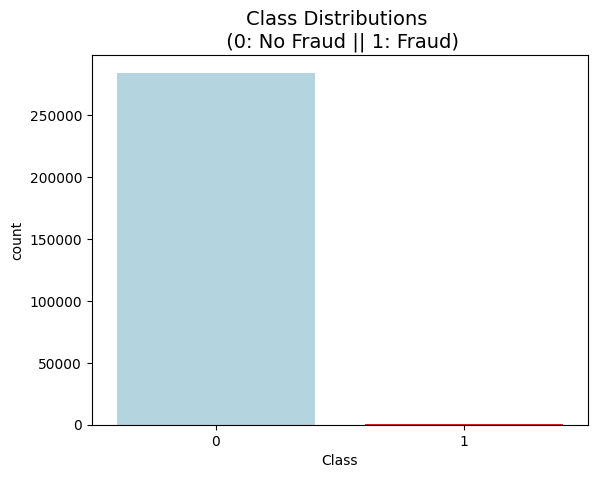

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
colors =  ['lightblue', 'red']
sns.countplot(x = 'Class', data=creditcard_data, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

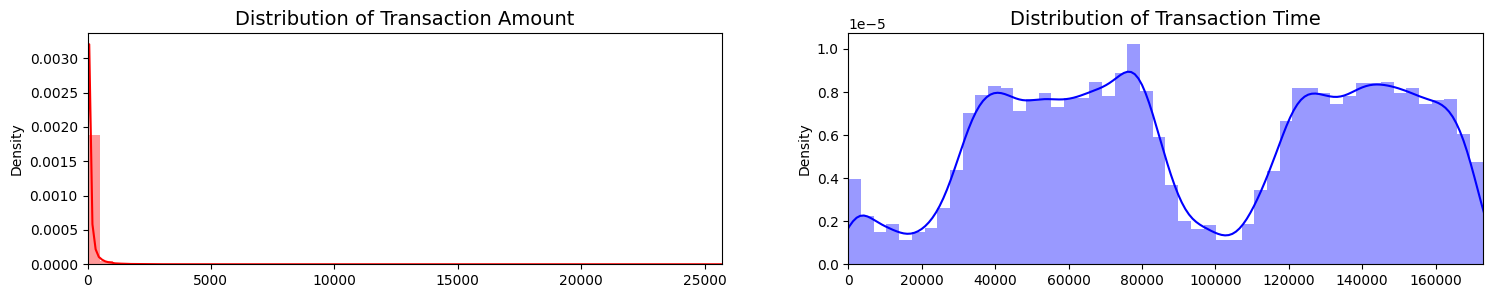

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(18,3))

amount_val = creditcard_data['Amount'].values
time_val = creditcard_data['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])
plt.show()

In [15]:
# Dataset mapping
datasets = {
    'credit_card': (creditcard_data, 'Class'),
    'fraud_data': (fraud_data, 'class')
}


In [16]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
# Function to prepare data
def prepare_data(df, target_column):
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    
    # Specify features based on the dataset
    if target_column == 'Class':  # Credit card dataset
        numeric_features = X.columns.tolist()
        categorical_features = []
    else:  # Fraud dataset
        numeric_features = ['purchase_value', 'age', 'transaction_frequency', 'purchase_time_diff', 'hour_of_day']
        categorical_features = ['source', 'browser', 'sex', 'country', 'day_of_week']
         
        # Drop unnecessary columns
        X = X.drop(['user_id', 'signup_time', 'purchase_time', 'device_id', 'ip_address', 'lower_bound_ip_address', 'upper_bound_ip_address'], axis=1)
  # Data transformation pipelines
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    
    X_preprocessed = preprocessor.fit_transform(X)
    
    # Splitting the dataset into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test, preprocessor

In [17]:
from sklearn.preprocessing import StandardScaler, RobustScaler

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

creditcard_data['scaled_amount'] = rob_scaler.fit_transform(creditcard_data['Amount'].values.reshape(-1,1))
creditcard_data['scaled_time'] = rob_scaler.fit_transform(creditcard_data['Time'].values.reshape(-1,1))

creditcard_data.drop(['Time','Amount'], axis=1, inplace=True)

In [18]:
# Function to evaluate the model
def evaluate_model(y_true, y_pred):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1_score': f1_score(y_true, y_pred)
    }

In [19]:
# Models to be trained
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'MLP': MLPClassifier()
}


In [20]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from sklearn.model_selection import train_test_split

def prepare_data(df, target_column):
    # Define features and target
    X = df.drop(columns=[target_column])
    y = df[target_column]
    
    # Identify numerical and categorical features
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X.select_dtypes(include=['object']).columns

    # Create a numeric transformer with mean imputation
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),  # Use 'mean' for numeric columns
    ])

    # Create a categorical transformer with constant imputation
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Combine transformers
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )

    # Preprocess the data
    X_preprocessed = preprocessor.fit_transform(X)

    # Splitting the dataset into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test, preprocessor


In [21]:
def process_credit_card_dataset(df, target_column):
    print("Processing Credit Card dataset")
    
    # Data preparation
    X_train, X_test, y_train, y_test, preprocessor = prepare_data(df, target_column)
    
    # Start an MLflow experiment
    with mlflow.start_run(run_name="credit_card_experiment"):
        for model_name, model in models.items():
            print(f"Training {model_name}")
            
            # Start nested runs for each model
            with mlflow.start_run(run_name=model_name, nested=True):
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                metrics = evaluate_model(y_test, y_pred)
                
                # Log parameters, metrics, and the model to MLflow
                mlflow.log_params(model.get_params())
                for metric_name, metric_value in metrics.items():
                    mlflow.log_metric(metric_name, metric_value)
                
                mlflow.sklearn.log_model(model, model_name)
                
                print(f"{model_name} metrics:")
                print(metrics)

        # Log the preprocessor
        mlflow.sklearn.log_model(preprocessor, "preprocessor")

In [22]:
def process_fraud_dataset(df, target_column):
    print("Processing Fraud dataset")
    
    # Data preparation
    X_train, X_test, y_train, y_test, preprocessor = prepare_data(df, target_column)
    
    # Convert to binary if needed
    if y_train.dtype == float or len(np.unique(y_train)) > 2:
        print("Converting target to binary")
        threshold = y_train.mean()  # Adjust this threshold as needed
        y_train = (y_train > threshold).astype(int)
        y_test = (y_test > threshold).astype(int)
    
    # Start an MLflow experiment
    with mlflow.start_run(run_name="fraud_experiment"):
        for model_name, model in models.items():
            print(f"Training {model_name}")
            
            # Start nested runs for each model
            with mlflow.start_run(run_name=model_name, nested=True):
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                metrics = evaluate_model(y_test, y_pred)
                
                # Log parameters, metrics, and the model to MLflow
                mlflow.log_params(model.get_params())
                for metric_name, metric_value in metrics.items():
                    mlflow.log_metric(metric_name, metric_value)
                
                mlflow.sklearn.log_model(model, model_name)
                
                print(f"{model_name} metrics:")
                print(metrics)

        # Log the preprocessor
        mlflow.sklearn.log_model(preprocessor, "preprocessor")

In [30]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import mlflow
from joblib import parallel_backend

def process_dataset(df, target_column, dataset_name):
    print(f"Processing {dataset_name} dataset")
    
    # Data preparation
    X_train, X_test, y_train, y_test, preprocessor = prepare_data(df, target_column)
    
    # Optional downsampling for quicker execution
    if X_train.shape[0] > 10000:  # Adjusted to use shape[0] instead of len()
        X_train, _, y_train, _ = train_test_split(X_train, y_train, train_size=0.1, stratify=y_train, random_state=42)
        print(f"Downsampled {dataset_name} to 10% of the original size for faster training")

    # Determine if it's a classification or regression task
    unique_values = np.unique(y_train)
    is_classification = len(unique_values) <= 10  # Adjust this threshold as needed

    if is_classification:
        # Convert to categorical if needed
        le = LabelEncoder()
        y_train = le.fit_transform(y_train)
        y_test = le.transform(y_test)
        
        # Optimize models with reduced complexity
        models = {
            'Logistic Regression': LogisticRegression(max_iter=500, n_jobs=-1),
            'Decision Tree': DecisionTreeClassifier(max_depth=5, min_samples_split=10, min_samples_leaf=5),
            'Random Forest': RandomForestClassifier(n_estimators=50, max_depth=5, min_samples_split=10, min_samples_leaf=5, max_features='sqrt', n_jobs=-1),
            'Gradient Boosting': GradientBoostingClassifier(n_estimators=50, max_depth=3, learning_rate=0.1, validation_fraction=0.2, n_iter_no_change=10),
            'MLP': MLPClassifier(hidden_layer_sizes=(50,), max_iter=200, early_stopping=True, n_iter_no_change=5)
        }
    else:
        print("Regression task detected. Skipping classification models.")
        return
    
    # Start an MLflow experiment
    with mlflow.start_run(run_name=f"{dataset_name}_experiment"):
        for model_name, model in models.items():
            print(f"Training {model_name}")
            
            # Start nested runs for each model
            with mlflow.start_run(run_name=model_name, nested=True):
                # Use joblib's parallel backend for scikit-learn
                with parallel_backend('threading', n_jobs=-1):
                    model.fit(X_train, y_train)
                
                y_pred = model.predict(X_test)
                metrics = evaluate_model(y_test, y_pred)
                
                # Log parameters, metrics, and the model to MLflow
                mlflow.log_params(model.get_params())
                for metric_name, metric_value in metrics.items():
                    mlflow.log_metric(metric_name, metric_value)
                
                mlflow.sklearn.log_model(model, model_name)
                
                print(f"{model_name} metrics:")
                print(metrics)

        # Log the preprocessor
        mlflow.sklearn.log_model(preprocessor, "preprocessor")

# Define your datasets with the appropriate target column names
datasets = {
    'creditcard': (creditcard_data, 'Class'),  # Assuming creditcard_df is the dataframe for credit card dataset
    'Fraud_Data': (fraud_data, 'class')  # Assuming fraud_data_df is the dataframe for fraud dataset
}

# Training and logging process
for dataset_name, (df, target_column) in datasets.items():
    process_dataset(df, target_column, dataset_name)

print("Model training and evaluation completed.")


Processing creditcard dataset
Downsampled creditcard to 10% of the original size for faster training
Training Logistic Regression


2024/10/24 17:11:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logistic Regression metrics:
{'accuracy': 0.9989642217618764, 'precision': 0.7532467532467533, 'recall': 0.5918367346938775, 'f1_score': 0.6628571428571428}
Training Decision Tree


2024/10/24 17:11:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Decision Tree metrics:
{'accuracy': 0.9988413328183702, 'precision': 0.6333333333333333, 'recall': 0.7755102040816326, 'f1_score': 0.6972477064220184}
Training Random Forest


2024/10/24 17:11:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Random Forest metrics:
{'accuracy': 0.9992275552122467, 'precision': 0.8648648648648649, 'recall': 0.6530612244897959, 'f1_score': 0.7441860465116279}
Training Gradient Boosting


2024/10/24 17:12:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Gradient Boosting metrics:
{'accuracy': 0.9988062216916541, 'precision': 0.631578947368421, 'recall': 0.7346938775510204, 'f1_score': 0.6792452830188679}
Training MLP


2024/10/24 17:12:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/24 17:12:28 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


MLP metrics:
{'accuracy': 0.9988588883817282, 'precision': 0.8367346938775511, 'recall': 0.41836734693877553, 'f1_score': 0.5578231292517006}


2024/10/24 17:12:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Processing Fraud_Data dataset
Downsampled Fraud_Data to 10% of the original size for faster training
Training Logistic Regression


2024/10/24 17:13:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logistic Regression metrics:
{'accuracy': 0.904807596863316, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0}
Training Decision Tree


2024/10/24 17:14:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Decision Tree metrics:
{'accuracy': 0.9040796744201436, 'precision': 0.13333333333333333, 'recall': 0.0013903371567605145, 'f1_score': 0.0027519779841761265}
Training Random Forest


2024/10/24 17:14:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Random Forest metrics:
{'accuracy': 0.904807596863316, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0}
Training Gradient Boosting


2024/10/24 17:14:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Gradient Boosting metrics:
{'accuracy': 0.904807596863316, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0}
Training MLP


2024/10/24 17:22:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


MLP metrics:
{'accuracy': 0.904807596863316, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0}


2024/10/24 17:22:20 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/10/24 17:22:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model training and evaluation completed.


In [33]:
import pandas as pd
import numpy as np
import mlflow
import mlflow.keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten, Dropout
import pickle

# Function to prepare data
def prepare_data(df, target_column):
    # Separate features and target
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Drop datetime columns if present
    X = X.select_dtypes(exclude=['datetime64[ns]'])

    # Ensure all remaining columns are numerical
    X = X.select_dtypes(include=[float, int])

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Apply scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    preprocessor = scaler
    return X_train, X_test, y_train, y_test, preprocessor

# Function to create CNN model
def create_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Change to softmax if multi-class
    return model

# Function to create LSTM model
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))  # Change to softmax if multi-class
    return model

# Function to create RNN model
def create_rnn_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))  # Change to softmax if multi-class
    return model

# Function to process each dataset
def process_dataset(df, target_column, dataset_name):
    print(f"Processing {dataset_name} dataset")

    # Data preparation
    X_train, X_test, y_train, y_test, preprocessor = prepare_data(df, target_column)

    # Reshape data for CNN and RNN
    X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # Define models
    models = {
        'CNN': create_cnn_model((X_train_cnn.shape[1], 1)),
        'LSTM': create_lstm_model((X_train_cnn.shape[1], 1)),
        'RNN': create_rnn_model((X_train_cnn.shape[1], 1))
    }

    # Training and logging process
    for model_name, model in models.items():
        with mlflow.start_run(run_name=model_name, nested=True):
            model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
            model.fit(X_train_cnn if model_name != 'CNN' else X_train,
                      y_train,
                      epochs=5,
                      batch_size=64,
                      validation_data=(X_test_cnn if model_name != 'CNN' else X_test, y_test))

            evaluation = model.evaluate(X_test_cnn if model_name != 'CNN' else X_test, y_test)
            mlflow.log_metric('loss', evaluation[0])
            mlflow.log_metric('accuracy', evaluation[1])

            # Save model as .pkl file
            model.save(f"{dataset_name}_{model_name}.h5")
            with open(f"{dataset_name}_{model_name}.pkl", 'wb') as f:
                pickle.dump(model, f)

# Load your datasets
creditcard_df = pd.read_csv('../data/creditcard.csv')
fraud_data_df = pd.read_csv('../data/fraud_data_preprocessed.csv')

# Define target columns
datasets = {
    'CreditCard': (creditcard_data, 'Class'),
    'FraudData': (fraud_data, 'class')
}

# Main processing loop
for dataset_name, (df, target_column) in datasets.items():
    process_dataset(df, target_column, dataset_name)

print("Model training, evaluation, and saving completed.")


Processing CreditCard dataset
Epoch 1/5
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.9985 - loss: 0.0141 - val_accuracy: 0.9992 - val_loss: 0.0036
Epoch 2/5
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.9993 - loss: 0.0039 - val_accuracy: 0.9993 - val_loss: 0.0032
Epoch 3/5
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.9994 - loss: 0.0033 - val_accuracy: 0.9992 - val_loss: 0.0034
Epoch 4/5
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.9993 - loss: 0.0033 - val_accuracy: 0.9993 - val_loss: 0.0030
Epoch 5/5
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.9994 - loss: 0.0028 - val_accuracy: 0.9994 - val_loss: 0.0029
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9994 - loss: 0.0020


Epoch 1/5
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 92s 25ms/step - accuracy: 0.9948 - loss: 0.0244 - val_accuracy: 0.9994 - val_loss: 0.0032
Epoch 2/5
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 95s 27ms/step - accuracy: 0.9994 - loss: 0.0034 - val_accuracy: 0.9993 - val_loss: 0.0030
Epoch 3/5
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 93s 26ms/step - accuracy: 0.9994 - loss: 0.0032 - val_accuracy: 0.9991 - val_loss: 0.0040
Epoch 4/5
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 89s 25ms/step - accuracy: 0.9994 - loss: 0.0034 - val_accuracy: 0.9993 - val_loss: 0.0030
Epoch 5/5
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 95s 27ms/step - accuracy: 0.9994 - loss: 0.0029 - val_accuracy: 0.9994 - val_loss: 0.0027
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9995 - loss: 0.0021


Epoch 1/5
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 85s 23ms/step - accuracy: 0.9956 - loss: 0.0246 - val_accuracy: 0.9993 - val_loss: 0.0033
Epoch 2/5
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 81s 23ms/step - accuracy: 0.9993 - loss: 0.0035 - val_accuracy: 0.9992 - val_loss: 0.0030
Epoch 3/5
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 82s 23ms/step - accuracy: 0.9994 - loss: 0.0030 - val_accuracy: 0.9993 - val_loss: 0.0030
Epoch 4/5
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 84s 24ms/step - accuracy: 0.9994 - loss: 0.0027 - val_accuracy: 0.9993 - val_loss: 0.0030
Epoch 5/5
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 92s 26ms/step - accuracy: 0.9994 - loss: 0.0031 - val_accuracy: 0.9994 - val_loss: 0.0028
1781/1781 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9995 - loss: 0.0021


Processing FraudData dataset
Epoch 1/5
1889/1889 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.0000e+00 - loss: -0.0119 - val_accuracy: 0.0000e+00 - val_loss: -0.3344
Epoch 2/5
1889/1889 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.0000e+00 - loss: -0.9280 - val_accuracy: 0.0000e+00 - val_loss: -2.0018
Epoch 3/5
1889/1889 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.0000e+00 - loss: -3.8957 - val_accuracy: 0.0000e+00 - val_loss: -5.9420
Epoch 4/5
1889/1889 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.0000e+00 - loss: -12.4905 - val_accuracy: 0.0000e+00 - val_loss: -13.3309
Epoch 5/5
1889/1889 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.0000e+00 - loss: -13.2202 - val_accuracy: 0.0000e+00 - val_loss: -23.3773
945/945 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.0000e+00 - loss: -41.7016


Epoch 1/5
1889/1889 ━━━━━━━━━━━━━━━━━━━━ 28s 13ms/step - accuracy: 0.0000e+00 - loss: 0.0199 - val_accuracy: 0.0000e+00 - val_loss: -3.1278e-04
Epoch 2/5
1889/1889 ━━━━━━━━━━━━━━━━━━━━ 26s 13ms/step - accuracy: 0.0000e+00 - loss: 0.0280 - val_accuracy: 0.0000e+00 - val_loss: 0.0035
Epoch 3/5
1889/1889 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.0000e+00 - loss: -0.0453 - val_accuracy: 0.0000e+00 - val_loss: -0.0048
Epoch 4/5
1889/1889 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - accuracy: 0.0000e+00 - loss: -0.0289 - val_accuracy: 0.0000e+00 - val_loss: -0.0297
Epoch 5/5
1889/1889 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.0000e+00 - loss: -0.0379 - val_accuracy: 0.0000e+00 - val_loss: -0.0917
945/945 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.0000e+00 - loss: -0.1678


Epoch 1/5
1889/1889 ━━━━━━━━━━━━━━━━━━━━ 28s 13ms/step - accuracy: 0.0000e+00 - loss: 0.0630 - val_accuracy: 0.0000e+00 - val_loss: -0.0014
Epoch 2/5
1889/1889 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - accuracy: 0.0000e+00 - loss: -0.0101 - val_accuracy: 0.0000e+00 - val_loss: -0.0133
Epoch 3/5
1889/1889 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - accuracy: 0.0000e+00 - loss: -0.0207 - val_accuracy: 0.0000e+00 - val_loss: -0.0513
Epoch 4/5
1889/1889 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - accuracy: 0.0000e+00 - loss: -0.0739 - val_accuracy: 0.0000e+00 - val_loss: -0.1281
Epoch 5/5
1889/1889 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - accuracy: 0.0000e+00 - loss: -0.2521 - val_accuracy: 0.0000e+00 - val_loss: -0.2283
945/945 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.0000e+00 - loss: -0.3892


Model training, evaluation, and saving completed.
